# PROJECT 1: Biodiversity in National Parks
**Author:** Arnau Murillo Pugès

**Date:** 23/20/2024

## 1. Introduction
Biodiversity is a key indicator of ecosystem health, and understanding how species are distributed across natural parks can provide valuable insights into conservation efforts. In this project, a descriptive statistical analysis is performed to explore biodiversity across several natural parks, particularly around various species observed in different national park locations. This project will scope, analyze, prepare, plot data, and seek to explain the findings from the analysis by exploring two datasets that provide information about various species and their conservation status.

#### Goals
1. To determine the distribution of conservation status by species category.
2. To assess whether certain categories of species are more likely to be endangered and evaluate is those diferences are estadistically significant.
3. To identify which animal is most prevalent and analyze their distribution across parks.

#### Datasets
Two datasets will be used: 'Observations.csv' and 'Species_info.csv'. Both datasets are provided by [Codecademy](https://www.codecademy.com). Both datasets are *inspired* by real data, but are mostly fictional.

## 2. Analysis
In this section, descriptive statistics and data visualization techniques will be employed to gain a deeper understanding of the data. Key metrics to be considered include distributions, counts, the relationships between species, the conservation status of various species, and the observations of species within the parks.

The libraries needed for this analysis are Numpy and Polars por Data Analysis and Matplotlib, Seaborn and Altair for Data Visualization. Scipy.stats, chain and Counter will also be used.

In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import scipy.stats as stats
import string
from itertools import chain
from collections import Counter

#### 2.1. Load
The first step is to load the datasets into DataFrames. It is important to specify *encoding='utf-8* in order to be able to represent characters from most of the world's languages if necessary.

In [2]:
df_obs = pl.read_csv('observations.csv', encoding='utf-8')
df_spe = pl.read_csv('species_info.csv', encoding='utf-8')

#### 2.2. Exploration
Once the datasets have been loaded, it is convenient to see what structure and size they have. Using the commands below we see that:

- The table of observations has 3 columns and 23.296 rows. In each row there is the scientific name of the species in question *(str format)*, the name of the park where it has been seen *(str format)* and the number of observations of that species there have been in the last 7 days *(int64 format)*.
- The species table has 4 columns and 5.825 rows. In each row there is The category of taxonomy for each species *(str format)*, the scientific name of the species *(str format)*, some common names *(str format)* and its conservation status *(str format)*.

In [3]:
print(df_obs.head())
print('The shape of the Observations.csv dataset is: ', df_obs.shape)

shape: (5, 3)
┌──────────────────────────┬─────────────────────────────────┬──────────────┐
│ scientific_name          ┆ park_name                       ┆ observations │
│ ---                      ┆ ---                             ┆ ---          │
│ str                      ┆ str                             ┆ i64          │
╞══════════════════════════╪═════════════════════════════════╪══════════════╡
│ Vicia benghalensis       ┆ Great Smoky Mountains National… ┆ 68           │
│ Neovison vison           ┆ Great Smoky Mountains National… ┆ 77           │
│ Prunus subcordata        ┆ Yosemite National Park          ┆ 138          │
│ Abutilon theophrasti     ┆ Bryce National Park             ┆ 84           │
│ Githopsis specularioides ┆ Great Smoky Mountains National… ┆ 85           │
└──────────────────────────┴─────────────────────────────────┴──────────────┘
The shape of the Observations.csv dataset is:  (23296, 3)


In [4]:
print(df_spe.head())
print('The shape of the Species_info.csv dataset is: ', df_spe.shape)

shape: (5, 4)
┌──────────┬───────────────────────────────┬─────────────────────────────────┬─────────────────────┐
│ category ┆ scientific_name               ┆ common_names                    ┆ conservation_status │
│ ---      ┆ ---                           ┆ ---                             ┆ ---                 │
│ str      ┆ str                           ┆ str                             ┆ str                 │
╞══════════╪═══════════════════════════════╪═════════════════════════════════╪═════════════════════╡
│ Mammal   ┆ Clethrionomys gapperi gapperi ┆ Gapper's Red-Backed Vole        ┆ null                │
│ Mammal   ┆ Bos bison                     ┆ American Bison, Bison           ┆ null                │
│ Mammal   ┆ Bos taurus                    ┆ Aurochs, Aurochs, Domestic Cat… ┆ null                │
│ Mammal   ┆ Ovis aries                    ┆ Domestic Sheep, Mouflon, Red S… ┆ null                │
│ Mammal   ┆ Cervus elaphus                ┆ Wapiti Or Elk                   

After confirming that all columns are correctly formatted, the next step involves checking for missing values. The following commands indicate that, aside from the conservation status column, there are no null values in the records. It is necessary to investigate the reasons behind the high number of null values in the conservation status column (5.633 out of 5824). This column represents a categorical variable with the following categories: Species of Concern, Threatened, Recovering, and Endangered. In the absence of a category indicating no threat to the species, it will be assumed that the null values correspond to species not at risk (it would be necessary to review the data source to confirm that this assumption is accurate and that no species have been overlooked in terms of their conservation status).

In [5]:
print('Null values per column in Observations.csv Dataset', df_obs.select(pl.all().null_count()))
print('Null values per column in Species_info.csv Dataset', df_spe.select(pl.all().null_count()))
print('Categories in the conservation_status column', df_spe.group_by("conservation_status").len())

Null values per column in Observations.csv Dataset shape: (1, 3)
┌─────────────────┬───────────┬──────────────┐
│ scientific_name ┆ park_name ┆ observations │
│ ---             ┆ ---       ┆ ---          │
│ u32             ┆ u32       ┆ u32          │
╞═════════════════╪═══════════╪══════════════╡
│ 0               ┆ 0         ┆ 0            │
└─────────────────┴───────────┴──────────────┘
Null values per column in Species_info.csv Dataset shape: (1, 4)
┌──────────┬─────────────────┬──────────────┬─────────────────────┐
│ category ┆ scientific_name ┆ common_names ┆ conservation_status │
│ ---      ┆ ---             ┆ ---          ┆ ---                 │
│ u32      ┆ u32             ┆ u32          ┆ u32                 │
╞══════════╪═════════════════╪══════════════╪═════════════════════╡
│ 0        ┆ 0               ┆ 0            ┆ 5633                │
└──────────┴─────────────────┴──────────────┴─────────────────────┘
Categories in the conservation_status column shape: (5, 2)
┌─────

#### 2.3. Cleanising
It has been seen that there are no significant null values in the provided data sets, it remains to be investigated if there are duplicates in any of the data sets and what to do in each case. In the code below we see that observations.csv has 30 duplicate observations. However, as there is no column indicating the date and time of each observation, it is not possible to know whether these are due to an error or whether the same species has been observed in the same park the same number of times at two different times. The fact that comparing only the scientific name and the park name shows 2228 repeated observations supports the second hypothesis, so the duplicates remain as they are. It should be noted that, in case of contact with the source of the data, the source would be contacted for clarification.

In [6]:
obs_duplicate_count = df_obs.filter(pl.struct(df_obs.columns).is_duplicated()).shape[0]
print(f"Number of duplicated observations: {obs_duplicate_count}")

obs_duplicate_count_2 = df_obs.filter(pl.struct(["scientific_name", "park_name"]).is_duplicated()).shape[0]
print(f"Number of observations with duplicated scientific name and park name: {obs_duplicate_count_2}")

Number of duplicated observations: 30
Number of observations with duplicated scientific name and park name: 2228


Cleanising species.csv is a bit more tedious. We can see that there are no duplicate observations, but there are 557 duplicate scientific names. This may be due to several factors:
1. Some species are classified in two different categories.
2. Some species have more than one entry because they have different common names.
3. There is a species whose conservation status is not well classified.

In the code below we see that there are no cases of the first reason and only a few of the third.

In [7]:
spe_duplicate_count = df_spe.filter(pl.struct(["category", "scientific_name", "conservation_status", "common_names"]).is_duplicated()).shape[0]
print(f"Number of duplicated rows: {spe_duplicate_count}")

spe_duplicate_count_1 = df_spe.filter(pl.col("scientific_name").is_duplicated()).shape[0]
print(f"Number of duplicated scientific names: {spe_duplicate_count_1}")

spe_duplicate_count_2 = df_spe.filter(pl.struct(["category", "scientific_name"]).is_duplicated()).shape[0]
print(f"Number of observations with duplicated category and scientific name: {spe_duplicate_count_2}")

spe_duplicate_count_3 = df_spe.filter(pl.struct(["scientific_name", "conservation_status"]).is_duplicated()).shape[0]
print(f"Number of observations with duplicated scientific name and conservation status: {spe_duplicate_count_3}")

Number of duplicated rows: 0
Number of duplicated scientific names: 557
Number of observations with duplicated category and scientific name: 557
Number of observations with duplicated scientific name and conservation status: 554


To resolve cases of inconsistency in conservation status, let's first look at which rows have the same category and scientific name but different conservation statuses. There are two species that meet these conditions: Canis lupus and Oncorhynchus mykiss. This is because legislation in the USA is not uniform and the conservation status of a species varies according to the habitat and circumstances in which it is found. Given the circumstances and the small number of observations, where a species has more than one conservation status, the final conservation status is considered to be the most threatened, with the order of threat (from highest to lowest) being as follows: Endangered, Threatened, Species of Concern, In Recovery. Thus, Canis lupus will be considered Endangered and Oncorhynchus mykiss will be considered Threatened.

In [8]:
duplicated_by_name_category = df_spe.filter(pl.struct(["scientific_name", "category"]).is_duplicated())

different_status = duplicated_by_name_category.group_by(["scientific_name", "category"]).agg([
    pl.col("conservation_status").n_unique().alias("unique_status_count")
])

different_conservation_status = different_status.filter(pl.col("unique_status_count") > 1)

result = df_spe.join(different_conservation_status, on=["scientific_name", "category"])

print(result)

shape: (5, 5)
┌──────────┬─────────────────────┬─────────────────┬─────────────────────┬─────────────────────┐
│ category ┆ scientific_name     ┆ common_names    ┆ conservation_status ┆ unique_status_count │
│ ---      ┆ ---                 ┆ ---             ┆ ---                 ┆ ---                 │
│ str      ┆ str                 ┆ str             ┆ str                 ┆ u32                 │
╞══════════╪═════════════════════╪═════════════════╪═════════════════════╪═════════════════════╡
│ Mammal   ┆ Canis lupus         ┆ Gray Wolf       ┆ Endangered          ┆ 2                   │
│ Fish     ┆ Oncorhynchus mykiss ┆ Rainbow Trout   ┆ null                ┆ 2                   │
│ Mammal   ┆ Canis lupus         ┆ Gray Wolf, Wolf ┆ In Recovery         ┆ 2                   │
│ Fish     ┆ Oncorhynchus mykiss ┆ Rainbow Trout   ┆ Threatened          ┆ 2                   │
│ Mammal   ┆ Canis lupus         ┆ Gray Wolf, Wolf ┆ Endangered          ┆ 2                   │
└──────────┴────

In [9]:
df_spe_clean = df_spe.filter(
    ~(
        ((pl.col("category") == "Mammal") &
        (pl.col("scientific_name") == "Canis lupus") &
        (pl.col("conservation_status") == "In Recovery")) |
        ((pl.col("category") == "Fish") &
        (pl.col("scientific_name") == "Oncorhynchus mykiss") &
        (pl.col("conservation_status").is_null()))
    )
)
print(df_spe_clean)

shape: (5_822, 4)
┌────────────────┬────────────────────────┬──────────────────────────────────┬─────────────────────┐
│ category       ┆ scientific_name        ┆ common_names                     ┆ conservation_status │
│ ---            ┆ ---                    ┆ ---                              ┆ ---                 │
│ str            ┆ str                    ┆ str                              ┆ str                 │
╞════════════════╪════════════════════════╪══════════════════════════════════╪═════════════════════╡
│ Mammal         ┆ Clethrionomys gapperi  ┆ Gapper's Red-Backed Vole         ┆ null                │
│                ┆ gapperi                ┆                                  ┆                     │
│ Mammal         ┆ Bos bison              ┆ American Bison, Bison            ┆ null                │
│ Mammal         ┆ Bos taurus             ┆ Aurochs, Aurochs, Domestic Cat…  ┆ null                │
│ Mammal         ┆ Ovis aries             ┆ Domestic Sheep, Mouflon, Red 

To complete the cleansing of the dataset, all rows with the same category, scientific name and conservation status but different common names must be merged. The code below groups according to these three columns and merges all possible names. However, the names remain in a list of lists, so they cannot yet be used. The code below solves this problem.

In [10]:
df_spe_clean = df_spe_clean.group_by(["scientific_name", "category", "conservation_status"]).agg([
    pl.col("common_names").implode()
])
common_names_list = df_spe_clean["common_names"].to_list()
flattened_common_names = [
    ", ".join([name for sublist in names for name in sublist]) if names else "" for names in common_names_list
]
df_spe_clean = df_spe_clean.with_columns(
    pl.Series("common_names", flattened_common_names)
)
print(df_spe_clean)

shape: (5_541, 4)
┌─────────────────────────────┬────────────────┬─────────────────────┬─────────────────────────────┐
│ scientific_name             ┆ category       ┆ conservation_status ┆ common_names                │
│ ---                         ┆ ---            ┆ ---                 ┆ ---                         │
│ str                         ┆ str            ┆ str                 ┆ str                         │
╞═════════════════════════════╪════════════════╪═════════════════════╪═════════════════════════════╡
│ Bufo americanus americanus  ┆ Amphibian      ┆ null                ┆ Eastern American Toad       │
│ Inula helenium              ┆ Vascular Plant ┆ null                ┆ Elecampane Inula            │
│ Lobelia spicata var.        ┆ Vascular Plant ┆ null                ┆ Lobelia                     │
│ leptostac…                  ┆                ┆                     ┆                             │
│ Paronychia argyrocoma       ┆ Vascular Plant ┆ null                ┆ Si

Finally, it is appropriate to assign a category to all null status conservation values. In this case it will be 'No Intervention'.

In [11]:
df_spe_clean = df_spe_clean.with_columns(
    pl.col("conservation_status").fill_null("No Intervention")
)
print(df_spe_clean)

shape: (5_541, 4)
┌─────────────────────────────┬────────────────┬─────────────────────┬─────────────────────────────┐
│ scientific_name             ┆ category       ┆ conservation_status ┆ common_names                │
│ ---                         ┆ ---            ┆ ---                 ┆ ---                         │
│ str                         ┆ str            ┆ str                 ┆ str                         │
╞═════════════════════════════╪════════════════╪═════════════════════╪═════════════════════════════╡
│ Bufo americanus americanus  ┆ Amphibian      ┆ No Intervention     ┆ Eastern American Toad       │
│ Inula helenium              ┆ Vascular Plant ┆ No Intervention     ┆ Elecampane Inula            │
│ Lobelia spicata var.        ┆ Vascular Plant ┆ No Intervention     ┆ Lobelia                     │
│ leptostac…                  ┆                ┆                     ┆                             │
│ Paronychia argyrocoma       ┆ Vascular Plant ┆ No Intervention     ┆ Si

#### 2.4. Analysis
Once the data has been explored and cleaned, it is time to respond to the 4 objectives set at the beginning of the project. This section will break down each of the objectives.
##### 2.4.1. To determine the distribution of conservation status by species category
The categories according to which the species are divided in this dataset are: Vascular Plant, Nonvascular Plant, Fish, Amphibe, Reptile, Bird and Mammal. The table below shows how many species are endangered in each category.

In [12]:
print(df_spe_clean.group_by("category").len())

df_spe_pivot = df_spe_clean.filter(
    pl.col("conservation_status") != "No Intervention"
).group_by(["conservation_status", "category"]).agg(
    pl.col("conservation_status").count().alias("count")
).pivot(
    values = "count",
    index ="conservation_status", 
    on ="category"
)

df_spe_pivot = df_spe_pivot.with_columns(
    pl.when(pl.col("conservation_status") == "Threatened").then(0)
    .when(pl.col("conservation_status") == "Endangered").then(1)
    .when(pl.col("conservation_status") == "In Recovery").then(2)
    .when(pl.col("conservation_status") == "Species of Concern").then(3)
    .otherwise(None).alias("conservation_status_order")
)
df_spe_pivot = df_spe_pivot.sort("conservation_status_order")
print(df_spe_pivot)

shape: (7, 2)
┌───────────────────┬──────┐
│ category          ┆ len  │
│ ---               ┆ ---  │
│ str               ┆ u32  │
╞═══════════════════╪══════╡
│ Amphibian         ┆ 79   │
│ Vascular Plant    ┆ 4262 │
│ Reptile           ┆ 78   │
│ Nonvascular Plant ┆ 333  │
│ Mammal            ┆ 176  │
│ Bird              ┆ 488  │
│ Fish              ┆ 125  │
└───────────────────┴──────┘
shape: (4, 9)
┌────────────────┬──────┬────────┬──────┬───┬───────────┬────────────────┬─────────┬───────────────┐
│ conservation_s ┆ Bird ┆ Mammal ┆ Fish ┆ … ┆ Amphibian ┆ Nonvascular    ┆ Reptile ┆ conservation_ │
│ tatus          ┆ ---  ┆ ---    ┆ ---  ┆   ┆ ---       ┆ Plant          ┆ ---     ┆ status_order  │
│ ---            ┆ u32  ┆ u32    ┆ u32  ┆   ┆ u32       ┆ ---            ┆ u32     ┆ ---           │
│ str            ┆      ┆        ┆      ┆   ┆           ┆ u32            ┆         ┆ i32           │
╞════════════════╪══════╪════════╪══════╪═══╪═══════════╪════════════════╪═════════╪══════

The graphs below show the distribution of the number of the different endangered listings according to species category. The first graph compares the different species categories and the second shows the quantity in aggregate.

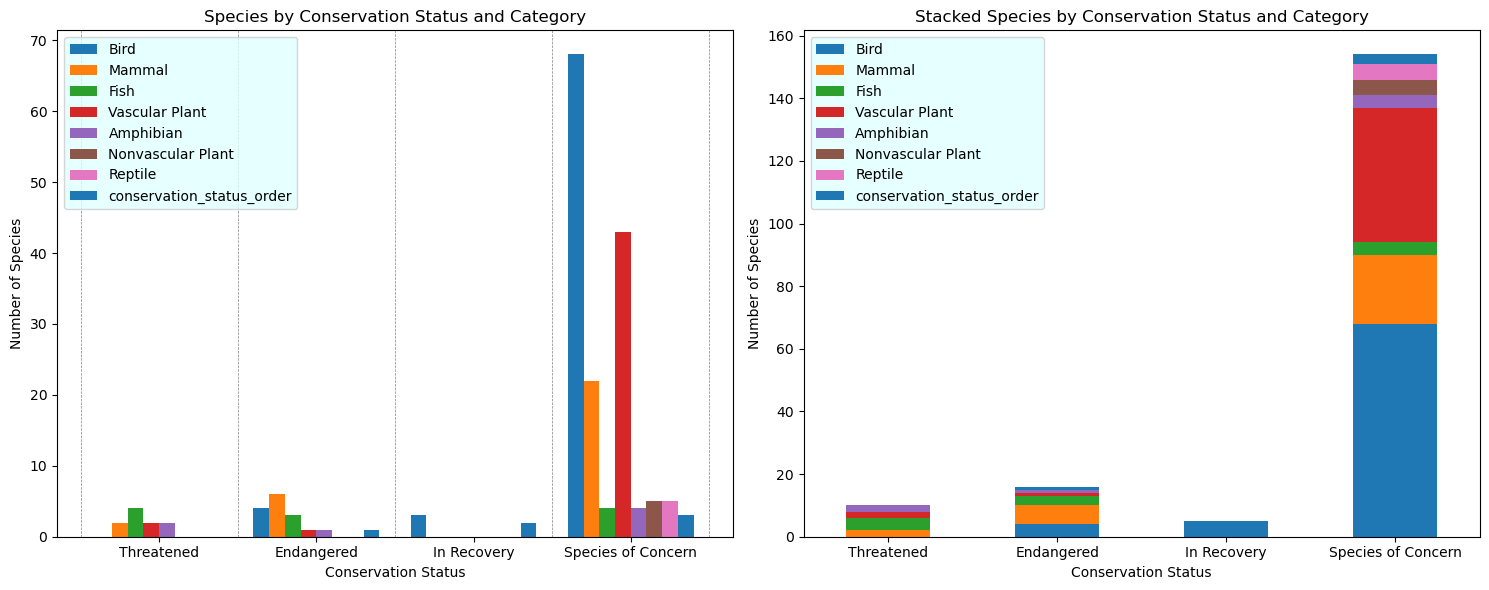

In [13]:
conservation_labels = ["Threatened", "Endangered", "In Recovery", "Species of Concern"]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

df_spe_pivot.to_pandas().plot(kind='bar', ax = axes[0], width = 0.8, color=sns.color_palette("tab10", n_colors=7))
axes[0].set_title("Species by Conservation Status and Category")
axes[0].set_xlabel('Conservation Status')
axes[0].set_ylabel('Number of Species')
axes[0].set_xticks(range(len(conservation_labels)))
axes[0].set_xticklabels(conservation_labels, rotation=0)
for i in range(0, len(conservation_labels) + 1):
    axes[0].axvline(x = i-0.5, color = 'grey', linestyle = '--', linewidth = 0.5)
axes[0].legend(loc = 'upper left', frameon = True, facecolor = 'lightcyan')

df_spe_pivot.to_pandas().plot(kind='bar', stacked = "True", ax = axes[1], color=sns.color_palette("tab10", n_colors=7))
axes[1].set_title("Stacked Species by Conservation Status and Category")
axes[1].set_xlabel('Conservation Status')
axes[1].set_ylabel('Number of Species')
axes[1].set_xticklabels(conservation_labels, rotation=0)
axes[1].legend(loc = 'upper left', frameon = True, facecolor = 'lightcyan')

plt.tight_layout()
plt.show()

##### 2.4.2. To assess whether certain categories of species are more likely to be endangered and evaluate is those diferences are estadistically significant
As mentioned above, the graph shows that Vascular plants and Birds are the species types with the most interventions. However, it should be noted that absolute numbers usually do not give the full picture, so it is also necessary to look at relative numbers. The table below shows both absolute and relative numbers.

In [14]:
df_spe_clean_aux = df_spe_clean
df_spe_clean_aux = df_spe_clean_aux.with_columns(
   pl.when(pl.col("conservation_status") != "No Intervention")
     .then(pl.lit(True))
     .otherwise(pl.lit(False))
     .alias("is_protected")
)

df_spe_pivot_2 = df_spe_clean_aux.group_by(["is_protected", "category"]).agg(
    pl.col("conservation_status").count().alias("count")
).pivot(
    values = "count",
    index ="category", 
    on ="is_protected"
)
df_spe_pivot_2 = df_spe_pivot_2.rename({
    "true": "Is Protected", 
    "false": "Is Not Protected"
})
df_spe_pivot_2 = df_spe_pivot_2.with_columns(
    (pl.col("Is Protected") / (pl.col("Is Protected") + pl.col("Is Not Protected"))*100)
    .alias("Protected Percentage")
)
print(df_spe_pivot_2)

shape: (7, 4)
┌───────────────────┬──────────────┬──────────────────┬──────────────────────┐
│ category          ┆ Is Protected ┆ Is Not Protected ┆ Protected Percentage │
│ ---               ┆ ---          ┆ ---              ┆ ---                  │
│ str               ┆ u32          ┆ u32              ┆ f64                  │
╞═══════════════════╪══════════════╪══════════════════╪══════════════════════╡
│ Amphibian         ┆ 7            ┆ 72               ┆ 8.860759             │
│ Bird              ┆ 75           ┆ 413              ┆ 15.368852            │
│ Fish              ┆ 11           ┆ 114              ┆ 8.8                  │
│ Vascular Plant    ┆ 46           ┆ 4216             ┆ 1.079305             │
│ Reptile           ┆ 5            ┆ 73               ┆ 6.410256             │
│ Mammal            ┆ 30           ┆ 146              ┆ 17.045455            │
│ Nonvascular Plant ┆ 5            ┆ 328              ┆ 1.501502             │
└───────────────────┴──────────────┴──

##### 2.4.3. To identify which animal is most prevalent and analyze their distribution across parks
The table above shows that mammals and birds have a much higher percentage of protection than amphibians, fish and reptiles, and amphibians, fish and reptiles have a much higher percentage of protection than plants. The question is whether these differences are significant or whether they are due to chance. A chi-square test is then performed to confirm that it is not chance that animals receive more protection than plants. The p-value, which is of the order of 10^-85, is less than 0.05 and therefore the difference in species proportions between animals and plants is significant.

In [15]:
contingency_table = df_spe_pivot_2.with_columns(
    pl.when((pl.col("category") == "Amphibian") | 
             (pl.col("category") == "Bird") | 
             (pl.col("category") == "Fish") | 
             (pl.col("category") == "Mammal") | 
             (pl.col("category") == "Reptile"))
    .then(pl.lit("Animal"))
    .otherwise(pl.lit("Plant"))
    .alias("is_animal")
).group_by("is_animal").agg(
    pl.col("Is Protected").sum().alias("Is Protected"),
    pl.col("Is Not Protected").sum().alias("Is Not Protected")
)
print(contingency_table)
contingency_array = contingency_table.select(
    ["Is Protected", "Is Not Protected"]
).to_numpy()

chi2, p, dof, expected = stats.chi2_contingency(contingency_array)
print("Chi-cuadrado:", chi2)
print("P-valor:", p)
print("Grados de libertad:", dof)
print("Frecuencias esperadas:", expected)

shape: (2, 3)
┌───────────┬──────────────┬──────────────────┐
│ is_animal ┆ Is Protected ┆ Is Not Protected │
│ ---       ┆ ---          ┆ ---              │
│ str       ┆ u32          ┆ u32              │
╞═══════════╪══════════════╪══════════════════╡
│ Animal    ┆ 128          ┆ 818              │
│ Plant     ┆ 51           ┆ 4544             │
└───────────┴──────────────┴──────────────────┘
Chi-cuadrado: 383.18835876370804
P-valor: 2.5165929051877095e-85
Grados de libertad: 1
Frecuencias esperadas: [[  30.56018769  915.43981231]
 [ 148.43981231 4446.56018769]]


##### 2.4.4. Identificación y análisis del animal predominante
In this part of the analysis we will focus on finding the animal that has been sighted the most in the last 7 seven days. It should be noted, for example, that within the wolf species there are Canis Lupus and Canis Rufus among others. For this analysis, it would be useful to know the order and family to which each species belongs, but as this is not available, the common names are used to group the animals. First, the species are filtered according to whether they are animals or plants.

In [16]:
df_spe_clean = df_spe_clean.with_columns(
    pl.when((pl.col("category") == "Amphibian") | 
             (pl.col("category") == "Bird") | 
             (pl.col("category") == "Fish") | 
             (pl.col("category") == "Mammal") | 
             (pl.col("category") == "Reptile"))
    .then(pl.lit("Animal"))
    .otherwise(pl.lit("Plant"))
    .alias("is_animal")
)

df_animals = df_spe_clean.filter(
    pl.col("is_animal") == 'Animal'
)
print(df_animals)


shape: (946, 5)
┌────────────────────────────┬───────────┬─────────────────────┬───────────────────────┬───────────┐
│ scientific_name            ┆ category  ┆ conservation_status ┆ common_names          ┆ is_animal │
│ ---                        ┆ ---       ┆ ---                 ┆ ---                   ┆ ---       │
│ str                        ┆ str       ┆ str                 ┆ str                   ┆ str       │
╞════════════════════════════╪═══════════╪═════════════════════╪═══════════════════════╪═══════════╡
│ Bufo americanus americanus ┆ Amphibian ┆ No Intervention     ┆ Eastern American Toad ┆ Animal    │
│ Euphagus cyanocephalus     ┆ Bird      ┆ No Intervention     ┆ Brewer's Blackbird    ┆ Animal    │
│ Megaceryle alcyon          ┆ Bird      ┆ No Intervention     ┆ Belted Kingfisher     ┆ Animal    │
│ Setophaga discolor         ┆ Bird      ┆ No Intervention     ┆ Prairie Warbler       ┆ Animal    │
│ Cottus gulosus             ┆ Fish      ┆ No Intervention     ┆ Riffle Scu

Next, the common_names column needs to be modified to identify and group the different words. This is done as follows: 
- First, remove all punctuation marks and write all names in lower case in a new column.
- Within a single observation, all repeated words are removed. They are also saved as a list. For example, if Canis lupus has Wolf and Gray wolf as common names, the content of the cell will be ['wolf', 'grey'].
- The .explode('word_list') command is used to create a new row for each word in word_list. Following the example above, the Canis Lupus column would be duplicated so that one observation contains 'wolf' and the other contains 'gray'.
- This table is merged with df_obs_total (this is the df_obs table which adds up the occurrences of each species in each park) in the scientific name column and grouped according to the word column. This gives the number of occurrences of each word.
- Finally, unnecessary columns are ignored and the result is sorted. Note that not all the words that appear are animal names, there are also adjectives. The word 'bat' is the first animal to appear in the list, so it is the animal with the most sightings.

In [17]:
df_animals_aux = df_animals.with_columns(
    pl.col("common_names").str.replace_all(r'[^\w\s]', '').str.to_lowercase().alias("word_list")
)

# Extraer las palabras únicas de 'clean_common_names' y crear una nueva columna con esas palabras
df_animals_aux = df_animals_aux.with_columns([
    pl.col("word_list").str.split(' ').alias("word_list")
])


# Explode para descomponer las listas en filas, de modo que cada palabra esté en su propia fila
exploded_df = df_animals_aux.explode("word_list")

df_obs_total = df_obs.group_by("scientific_name").agg(pl.sum("observations").alias("observations"))

# Filtrar solo las observaciones de animales (puedes ajustar este filtro)
observations_animals = df_obs_total.join(
    exploded_df, left_on = "scientific_name", right_on = "scientific_name", how = "right"
)

# Agrupar por la palabra (animal) en 'word_list' y sumar las observaciones
result = observations_animals.group_by("word_list").agg(
    pl.sum("observations").alias("total_observations")
)

# Ordenar los resultados para ver qué palabra (animal) tiene más observaciones
result = result.sort("total_observations", descending=True)

# Mostrar los 10 animales más observados
print(result.head(10))

shape: (10, 2)
┌────────────┬────────────────────┐
│ word_list  ┆ total_observations │
│ ---        ┆ ---                │
│ str        ┆ i64                │
╞════════════╪════════════════════╡
│ northern   ┆ 37954              │
│ warbler    ┆ 33535              │
│ bat        ┆ 31101              │
│ american   ┆ 29590              │
│ salamander ┆ 26276              │
│ eastern    ┆ 25747              │
│ common     ┆ 25661              │
│ western    ┆ 24699              │
│ shrew      ┆ 24220              │
│ myotis     ┆ 20946              │
└────────────┴────────────────────┘


Una vez identificado el murciélago como el animal con más avistamientos, toca analizar qué tipo de murciélagos se han avistado y cómo se han distribuído. La tabla de a continuación muestra la información relativa a los murciélagos y los gráficos de abajo dan una idea general sobre su situación.

In [18]:
df_bat = df_animals.filter(
    pl.col("common_names").str.contains(r"\bBat\b")
)
df_bat = df_bat.join(
    df_obs, left_on = "scientific_name", right_on = "scientific_name", how = "left"
)
print(df_bat)

shape: (100, 7)
┌───────────────┬──────────┬──────────────┬──────────────┬───────────┬──────────────┬──────────────┐
│ scientific_na ┆ category ┆ conservation ┆ common_names ┆ is_animal ┆ park_name    ┆ observations │
│ me            ┆ ---      ┆ _status      ┆ ---          ┆ ---       ┆ ---          ┆ ---          │
│ ---           ┆ str      ┆ ---          ┆ str          ┆ str       ┆ str          ┆ i64          │
│ str           ┆          ┆ str          ┆              ┆           ┆              ┆              │
╞═══════════════╪══════════╪══════════════╪══════════════╪═══════════╪══════════════╪══════════════╡
│ Eumops        ┆ Mammal   ┆ No           ┆ Western      ┆ Animal    ┆ Great Smoky  ┆ 40           │
│ perotis       ┆          ┆ Intervention ┆ Mastiff Bat  ┆           ┆ Mountains    ┆              │
│               ┆          ┆              ┆              ┆           ┆ National…    ┆              │
│ Eumops        ┆ Mammal   ┆ No           ┆ Western      ┆ Animal    ┆ Bryc

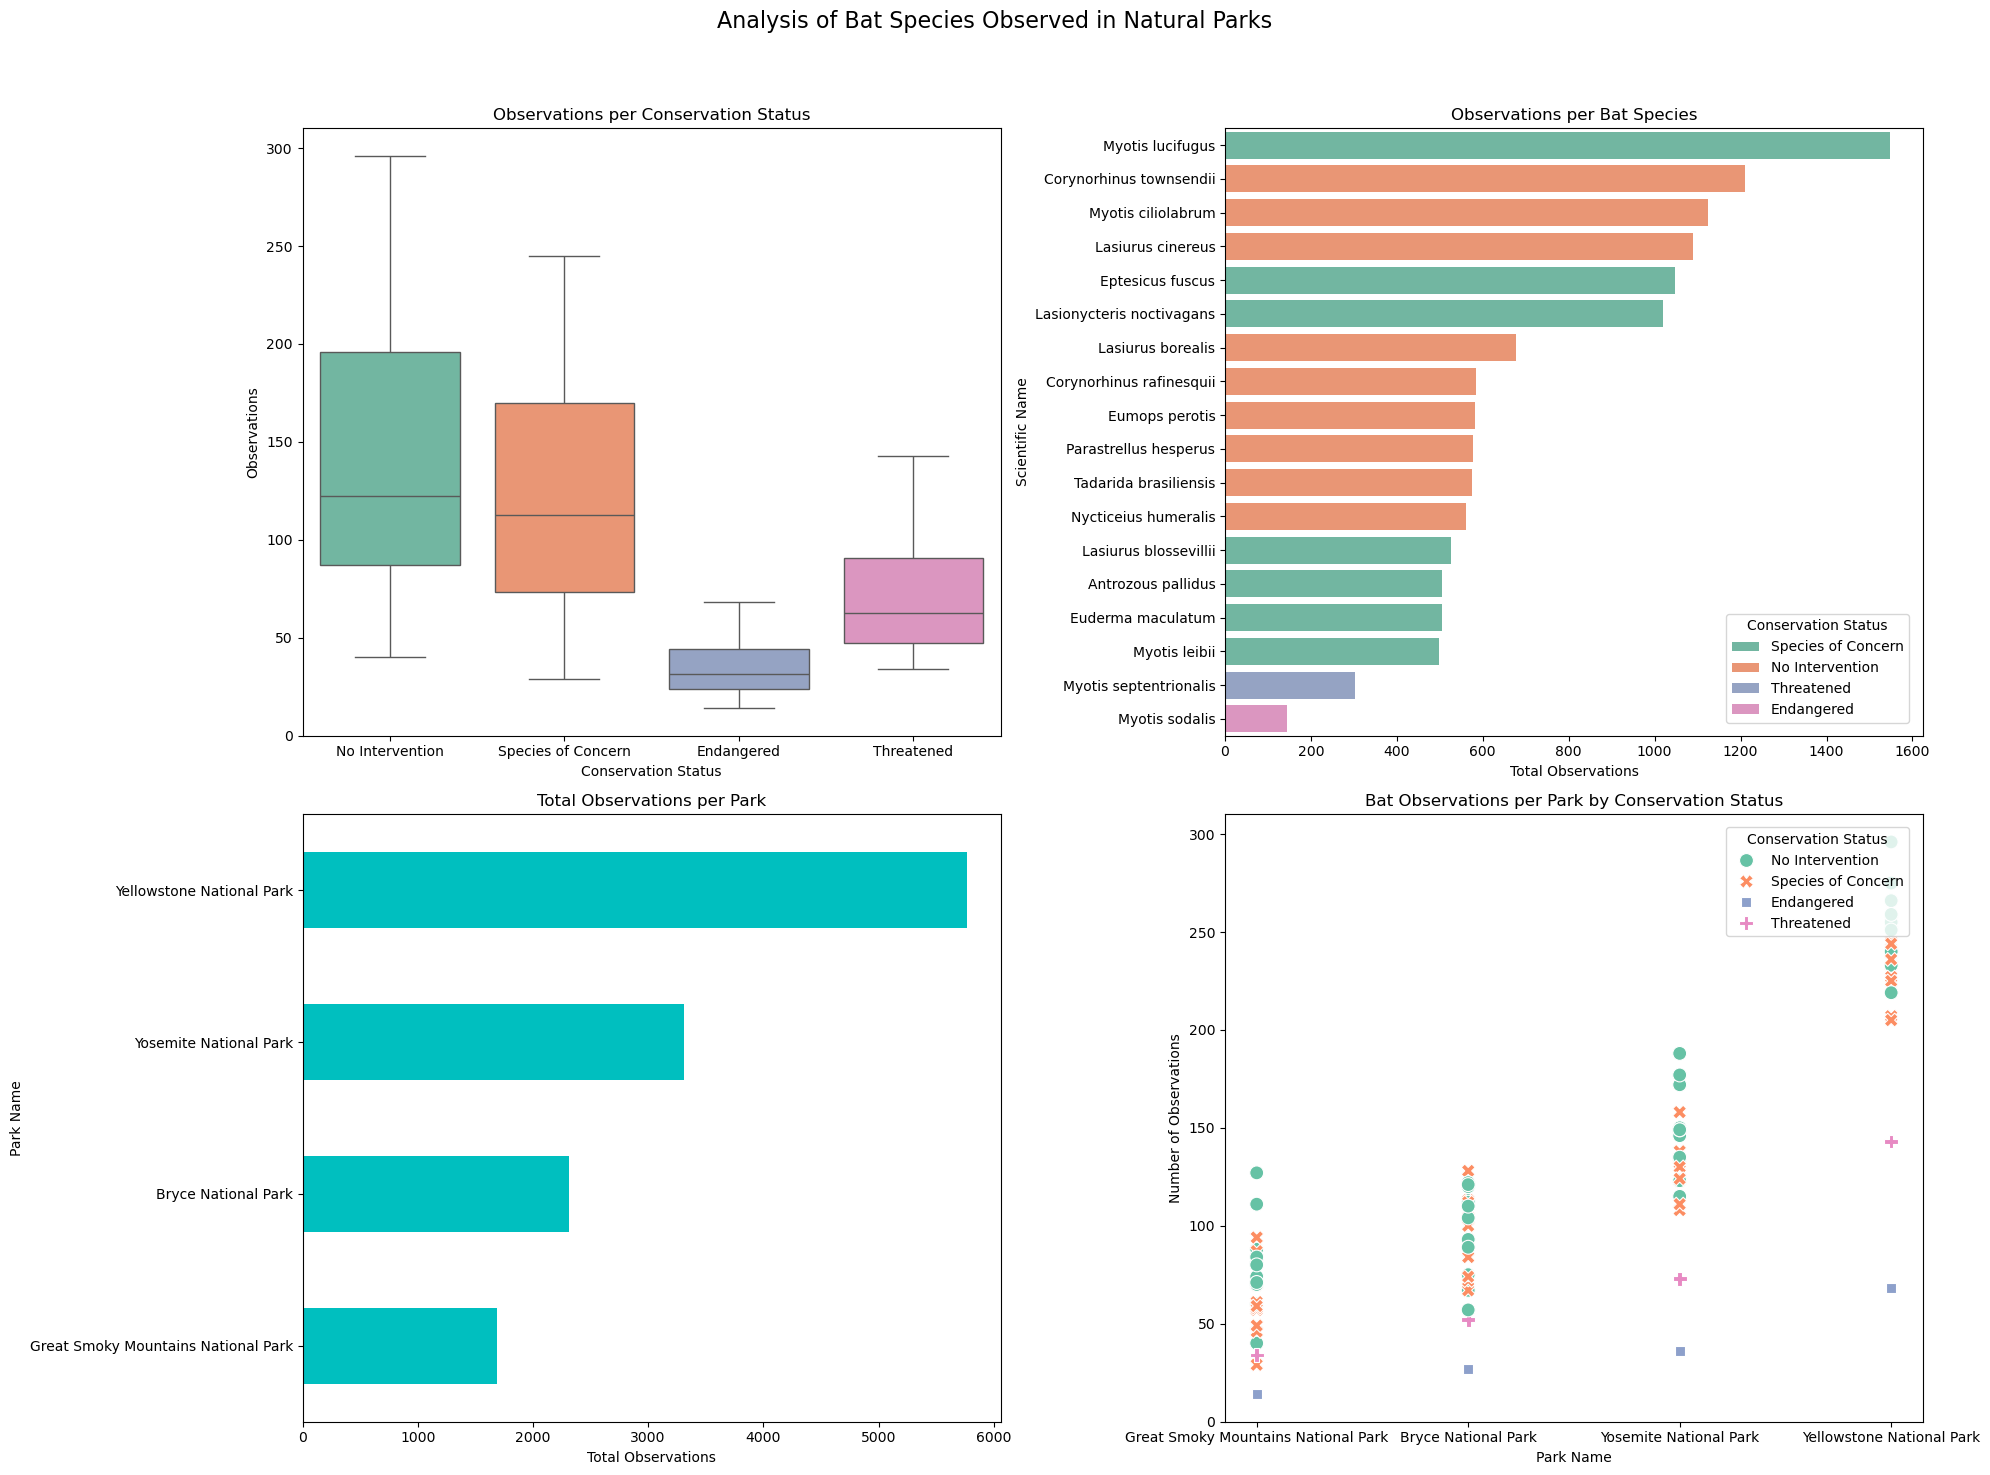

In [19]:
df_bat_pd = df_bat.to_pandas()

# Crear subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle("Analysis of Bat Species Observed in Natural Parks", fontsize=16)

# Gráfico 1: Boxplot de observaciones por parque según el estatus de conservación
sns.boxplot(x='conservation_status', y='observations', data=df_bat_pd, hue='conservation_status', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title('Observations per Conservation Status')
axs[0, 0].set_xlabel('Conservation Status')
axs[0, 0].set_ylabel('Observations')
axs[0, 0].tick_params(axis='x', rotation=0)

# Gráfico 2: Barras horizontales - Observaciones por especie de murciélago
df_species_obs = df_bat.group_by(['scientific_name', 'conservation_status']).agg(
    pl.col('observations').sum().alias('total_observations')
).sort('total_observations', descending=True)

# Convertir el resultado a Pandas para poder usarlo con Seaborn
df_species_obs_pd = df_species_obs.to_pandas()

sns.barplot(
    y='scientific_name', x='total_observations', data=df_species_obs_pd,  
    hue='conservation_status', dodge=False,  # Asignar colores basados en conservation_status
    palette='Set2', ax=axs[0, 1]
)

axs[0, 1].set_xlabel('Total Observations')
axs[0, 1].set_ylabel('Scientific Name')
axs[0, 1].set_title('Observations per Bat Species')

# Mover la leyenda a la parte inferior derecha
axs[0, 1].legend(title='Conservation Status', bbox_to_anchor=(0.99, 0.01), loc='lower right')

# Gráfico 3: Barras horizontales - Número total de avistamientos por parque
df_bat_pd.groupby('park_name')['observations'].sum().sort_values().plot(kind='barh', ax=axs[1, 0], color='c')
axs[1, 0].set_title('Total Observations per Park')
axs[1, 0].set_xlabel('Total Observations')
axs[1, 0].set_ylabel('Park Name')

# Gráfico 4: Scatter plot - Observaciones por parque y estatus de conservación
sns.scatterplot(
    data=df_bat_pd, x='park_name', y='observations',
    hue='conservation_status', style='conservation_status',
    palette='Set2', s=100, ax=axs[1, 1]
)

# Ajustes de etiquetas y título
axs[1, 1].set_title('Bat Observations per Park by Conservation Status')
axs[1, 1].set_xlabel('Park Name')
axs[1, 1].set_ylabel('Number of Observations')
axs[1, 1].tick_params(axis='x', rotation=0)
axs[1, 1].legend(title='Conservation Status', loc='upper right', bbox_to_anchor=(0.99, 0.99))


# Ajustar el diseño
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 3. Conclusions
The project gives an overview of the condition of the natural parks in the datasets and the species that inhabit them. It should be noted that only species sighted in the last 7 days have been considered, so a more in-depth and long-term analysis should include more data and dates. The initial doubts have been allayed:

- **To determine the distribution of conservation status by species category.**

Only 179 of the 5541 species are subject to some form of protection. Of these, almost all are Species of Concern, and the statuses Threatened, Endangered and In Recovery are rarely applied. At an environmental level, this can be interpreted to mean that most species do not require protection and those that do are at low risk. There are few species that require special attention or are threatened with extinction. In the long term, the evolution of all species should be monitored and sighting data should be used to re-categorise each species.

- **To assess whether certain categories of species are more likely to be endangered and evaluate is those diferences are estadistically significant.**

In absolute terms, vascular plants are the species most in need of protection. However, in relative terms, mammals and birds account for around 15% of protected species, compared with 8% for fish, amphibians and reptiles and 1% for plants. The difference in protection between animals and plants is significant and could have two implications:

1- Animals are more threatened and at greater risk of extinction.

2- Plants receive less attention.

We need to analyse whether it is one or the other, or a mixture of the two, and act accordingly. Another figure that could be studied in a more in-depth analysis is whether the differences between different types of animals (e.g. mammals and reptiles) are significant or not.

- **To identify which animal is most prevalent and analyze their distribution across parks.**

The bat is the animal most often seen in the last 7 days. There are 18 different species of bats, distributed as follows: 1 threatened, 1 endangered, 7 of concern, 0 recovering and 9 with no intervention. There are quite a few protected bat species compared to what was examined in the previous section. However, there are still quite a high proportion of sightings of bats classified as 'Species of Concern'. There are very few sightings of both 'Vulnerable' and 'Endangered' species.

Parks have different numbers of bat sightings, from highest to lowest: Yellowstone National Park, Yosemite National Park, Bryce National Park and Great Smoky Mountains National Park. One could compare the number of bats seen with the total number of animals, plants or land areas seen to see if there is an unknown cause for this difference. Despite this difference in numbers, the distribution of species is similar in all parks. The last graph shows that the more protected species are seen less everywhere and the less protected or unprotected species are seen more.